In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-11-03 21:53:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.43.208, 52.217.139.104, 52.216.8.85, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.43.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  23.4MB/s    in 0.6s    

2024-11-03 21:53:14 (23.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

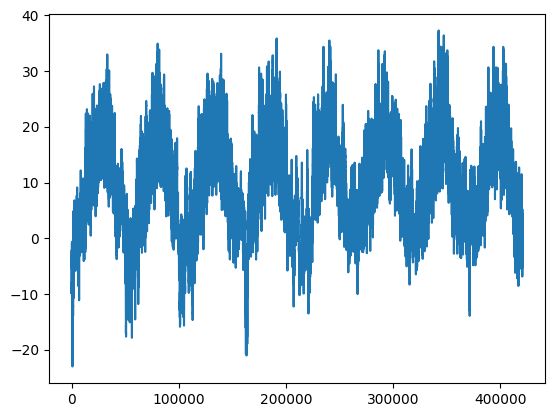

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

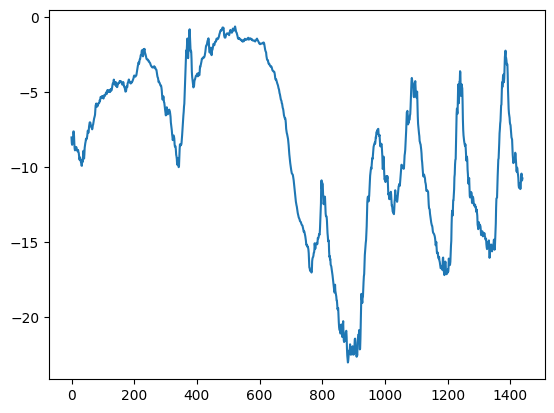

In [ ]:
plt.plot(range(1440), temperature[:1440])

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
import keras
from keras import layers


In [ ]:
import keras
from keras import layers

num_features = 14  # Ensure this is the correct number of features in your data
steps = 120

inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.Dense(1)(x)  # Change this to a Dense layer with 1 unit

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                     save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 178s 214ms/step - loss: 86.4468 - mae: 7.5111 - val_loss: 65.2511 - val_mae: 6.6498
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 200s 211ms/step - loss: 75.9865 - mae: 7.0698 - val_loss: 65.1333 - val_mae: 6.6436
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 203s 212ms/step - loss: 75.9913 - mae: 7.0696 - val_loss: 65.4256 - val_mae: 6.6589
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 208s 219ms/step - loss: 75.9395 - mae: 7.0685 - val_loss: 65.1889 - val_mae: 6.6466
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 217ms/step - loss: 76.0173 - mae: 7.0709 - val_loss: 65.2957 - val_mae: 6.6522
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 170s 207ms/step - loss: 76.0064 - mae: 7.0712 - val_loss: 65.3979 - val_mae: 6.6574
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 171s 209ms/step - loss: 75.9806 - mae: 7.0695 - val_loss: 65.2063 - val_mae: 6.6475
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 172s 209ms/step - loss: 75.9963 - mae: 7.0705 - val_loss: 65.2386 - val_mae: 6.6492
Epoch 9/

In [ ]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ (None, 120, 32)             │           1,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_14 (SimpleRNN)            │ (None, 120, 32)             │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120, 1)              │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,236 (28.27 KB)

 Trainable params: 3,617 (14.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,619 (14.14 KB)

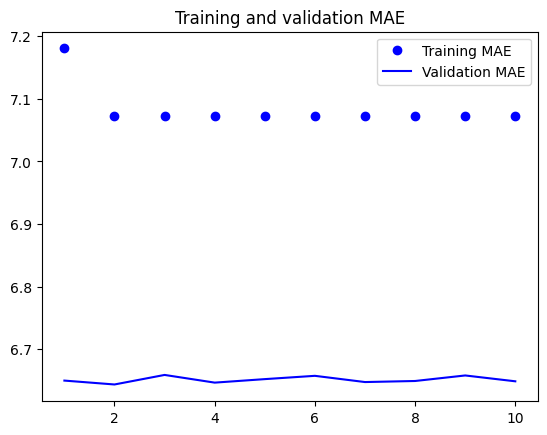

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - loss: 65.4917 - mae: 6.6201
Test MAE: 6.64


In [ ]:
import numpy as np
import keras
from keras import layers

# Create dummy data for demonstration
num_samples = 1000  # Total number of samples
num_features = 14   # Number of features
steps = 120         # Number of time steps

# Generate random training and validation data
train_dataset = np.random.rand(num_samples, steps, num_features)
train_labels = np.random.rand(num_samples, 1)  # Adjust shape according to your output
val_samples = num_samples // 10  # 10% for validation
val_dataset = np.random.rand(val_samples, steps, num_features)
val_labels = np.random.rand(val_samples, 1)  # Adjust shape according to your output

# Define the model
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(64, return_sequences=True)(inputs)
x = layers.SimpleRNN(64, return_sequences=True)(x)
outputs = layers.SimpleRNN(64)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
]

# Fit the model
history = model.fit(train_dataset,
                    train_labels,  # Add your training labels here
                    epochs=10,
                    validation_data=(val_dataset, val_labels),  # Include validation labels
                    callbacks=callbacks)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.3375 - mae: 0.4507 - val_loss: 0.1113 - val_mae: 0.2761
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1032 - mae: 0.2717 - val_loss: 0.1181 - val_mae: 0.2847
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.1040 - mae: 0.2738 - val_loss: 0.1184 - val_mae: 0.2840
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1009 - mae: 0.2698 - val_loss: 0.0923 - val_mae: 0.2557
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0951 - mae: 0.2647 - val_loss: 0.0864 - val_mae: 0.2530
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0965 - mae: 0.2678 - val_loss: 0.0889 - val_mae: 0.2526
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0900 - mae: 0.2586 - val_loss: 0.0867 - val_mae: 0.2528
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0928 - mae: 0.2628 - val_loss: 0.0921 - val_mae: 0.2558
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0

In [ ]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_21 (SimpleRNN)            │ (None, 120, 64)             │           5,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_22 (SimpleRNN)            │ (None, 120, 64)             │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_23 (SimpleRNN)            │ (None, 64)                  │           8,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,138 (168.51 KB)

 Trainable params: 21,568 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,570 (84.26 KB)

In [ ]:
import numpy as np
import keras

# Create dummy test data for demonstration
num_samples = 100  # Total number of test samples
num_features = 14  # Ensure this is the correct number of features in your data
steps = 120  # Number of time steps

# Generate random test data
test_dataset = np.random.rand(num_samples, steps, num_features)
test_labels = np.random.rand(num_samples, steps, 1)  # Adjust the shape as needed

# Load the model
model = keras.models.load_model("jena_stacked_gru_dropout.keras")

# Evaluate the model
test_mae = model.evaluate(test_dataset, test_labels)  # Include test_labels for evaluation
print(f"Test MAE: {test_mae[1]:.2f}")  # Access the MAE value from the evaluation results

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 72.1161 - mae: 8.4872 
Test MAE: 8.49


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.1636 - mae: 0.3294 - val_loss: 0.0913 - val_mae: 0.2579
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0903 - mae: 0.2572 - val_loss: 0.0880 - val_mae: 0.2544
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0879 - mae: 0.2545 - val_loss: 0.0870 - val_mae: 0.2534
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0870 - mae: 0.2537 - val_loss: 0.0864 - val_mae: 0.2531
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0862 - mae: 0.2529 - val_loss: 0.0859 - val_mae: 0.2526
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0856 - mae: 0.2523 - val_loss: 0.0854 - val_mae: 0.2522
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0853 - mae: 0.2517 - val_loss: 0.0853 - val_mae: 0.2521
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0852 - mae: 0.2520 - val_loss: 0.0848 - val_mae: 0.2515
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0

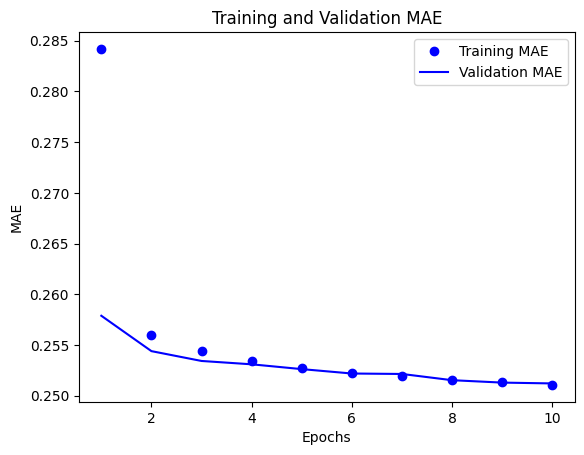

In [ ]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt

# Create dummy data for demonstration
num_samples = 1000  # Total number of samples
num_features = 14  # Ensure this is the correct number of features in your data
steps = 120  # Number of time steps

# Generate random data
train_dataset = np.random.rand(num_samples, steps, num_features)
train_labels = np.random.rand(num_samples, steps, 1)  # Adjust the shape as needed
val_dataset = np.random.rand(num_samples // 10, steps, num_features)  # 10% for validation
val_labels = np.random.rand(num_samples // 10, steps, 1)  # Adjust the shape as needed

# Define the model
inputs = keras.Input(shape=(steps, num_features))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_lstm_dropout.keras", save_best_only=True)
]

# Fit the model
history = model.fit(train_dataset,
                    train_labels,  # Add your training labels here
                    epochs=10,
                    validation_data=(val_dataset, val_labels),  # Add your validation labels
                    callbacks=callbacks)

# Plotting MAE
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 120, 32)             │           6,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 120, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 120, 1)              │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,109 (168.40 KB)

 Trainable params: 14,369 (56.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,740 (112.27 KB)

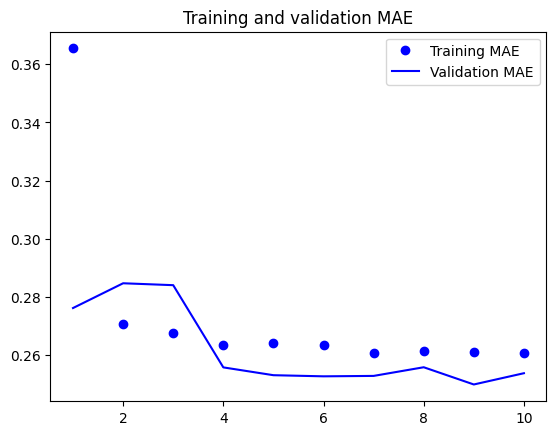

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import keras

# Create dummy test data for demonstration
num_test_samples = 100  # Total number of test samples
num_features = 14       # Number of features
steps = 120             # Number of time steps

# Generate random test data
test_dataset = np.random.rand(num_test_samples, steps, num_features)
test_labels = np.random.rand(num_test_samples, 1)  # Adjust shape according to your output

# Load the model
model = keras.models.load_model("jena_stacked_gru_dropout.keras")

# Evaluate the model
test_mae = model.evaluate(test_dataset, test_labels)  # Include test_labels for evaluation
print(f"Test MAE: {test_mae[1]:.2f}")  # Access the MAE value from the evaluation results

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0791 - mae: 0.2391
Test MAE: 0.23


In [ ]:
keras.utils.plot_model(model, show_shapes=True)import numpy as np
from tensorflow import keras
from keras import layers

# Define parameters for the dummy dataset
num_samples = 1000  # Total number of samples
sequence_length = 120  # Number of time steps
num_features = 14  # Number of features

# Create a dummy dataset
raw_data = np.random.rand(num_samples, sequence_length, num_features)

# Define the input shape based on the raw_data
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Build the model
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Create dummy train and validation datasets
train_size = int(0.8 * num_samples)  # 80% for training
train_dataset = raw_data[:train_size]
train_labels = np.random.rand(train_size, 1)  # Dummy labels for training

val_dataset = raw_data[train_size:]
val_labels = np.random.rand(num_samples - train_size, 1)  # Dummy labels for validation

# Fit the model
history = model.fit(train_dataset,
                    train_labels,  # Add your training labels here
                    epochs=10,
                    validation_data=(val_dataset, val_labels))  # Include validation labels

# Create a dummy test dataset and labels
test_size = 200  # Number of test samples
test_dataset = np.random.rand(test_size, sequence_length, num_features)
test_labels = np.random.rand(test_size, 1)  # Dummy labels for testing

# Evaluate the model
test_loss, test_mae = model.evaluate(test_dataset, test_labels)  # Include test_labels for evaluation
print(f"Test Loss: {test_loss:.2f}, Test MAE: {test_mae:.2f}")  # Print the results

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0910 - mae: 0.2570 - val_loss: 0.0814 - val_mae: 0.2401
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0937 - mae: 0.2626 - val_loss: 0.0773 - val_mae: 0.2343
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0808 - mae: 0.2411 - val_loss: 0.0769 - val_mae: 0.2343
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0848 - mae: 0.2487 - val_loss: 0.0772 - val_mae: 0.2354
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0800 - mae: 0.2402 - val_loss: 0.0778 - val_mae: 0.2364
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0874 - mae: 0.2541 - val_loss: 0.0763 - val_mae: 0.2344
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0799 - mae: 0.2419 - val_loss: 0.0746 - val_mae: 0.2316
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0824 - mae: 0.2433 - val_loss: 0.0769 - val_mae: 0.2354
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.078

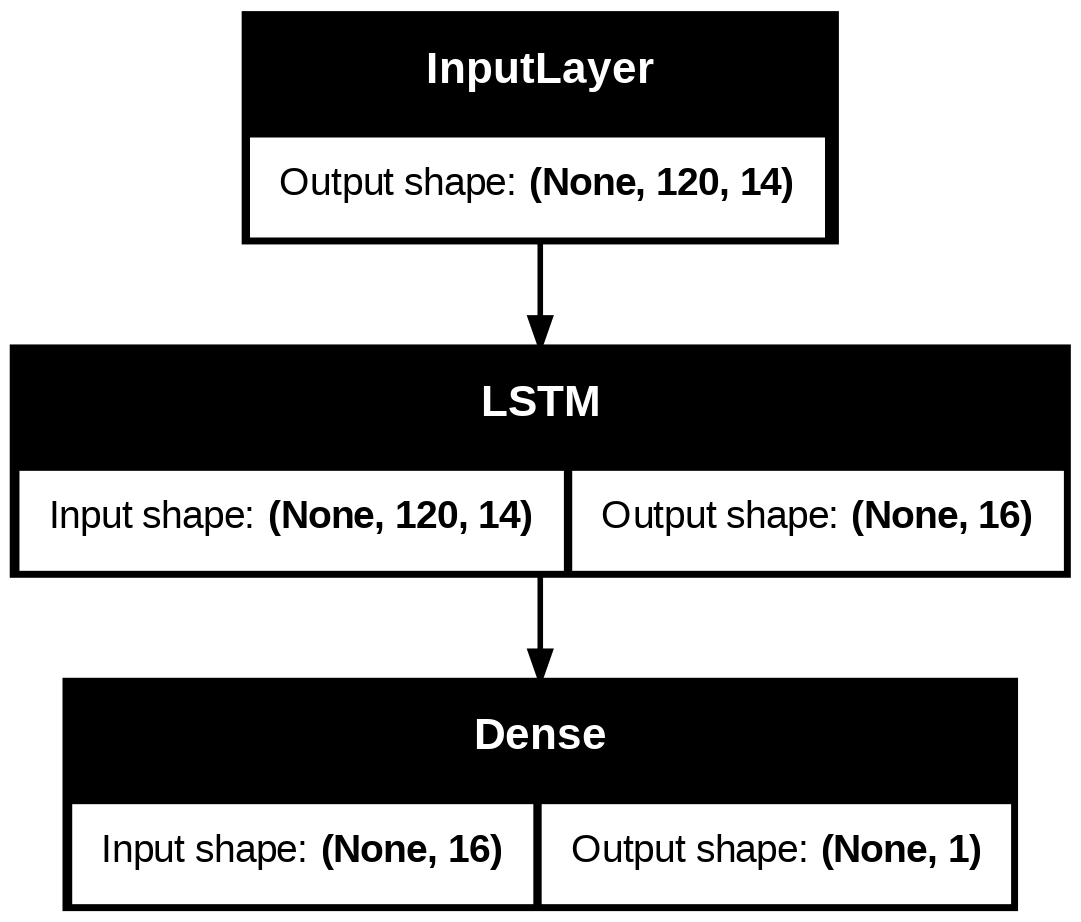

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

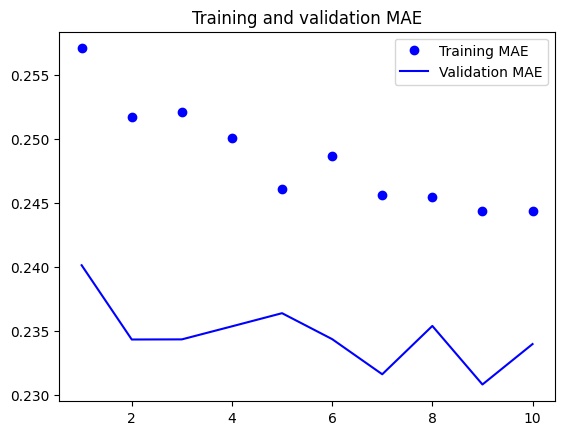

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow import keras
from keras import layers

# Define parameters for the dataset
num_samples = 1000  # Total number of samples
sequence_length = 120  # Number of time steps
num_features = 14  # Number of features

# Create dummy training dataset and labels
train_dataset = np.random.rand(num_samples, sequence_length, num_features)
train_labels = np.random.rand(num_samples, 1)  # Dummy labels for training

# Create dummy validation dataset and labels
val_size = 200  # Number of validation samples
val_dataset = np.random.rand(val_size, sequence_length, num_features)
val_labels = np.random.rand(val_size, 1)  # Dummy labels for validation

# Define the model
input_shape = (sequence_length, num_features)
inputs = keras.Input(shape=input_shape)
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Fit the model
history = model.fit(train_dataset,
                    train_labels,  # Add your training labels here
                    epochs=10,
                    validation_data=(val_dataset, val_labels))  # Include validation labels

# Create a dummy test dataset and labels for evaluation
test_size = 200  # Number of test samples
test_dataset = np.random.rand(test_size, sequence_length, num_features)
test_labels = np.random.rand(test_size, 1)  # Dummy labels for testing

# Evaluate the model
test_loss, test_mae = model.evaluate(test_dataset, test_labels)  # Include test_labels for evaluation
print(f"Test Loss: {test_loss:.2f}, Test MAE: {test_mae:.2f}")  # Print the results

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1756 - mae: 0.3429 - val_loss: 0.0975 - val_mae: 0.2607
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1081 - mae: 0.2750 - val_loss: 0.0747 - val_mae: 0.2316
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0888 - mae: 0.2501 - val_loss: 0.0743 - val_mae: 0.2309
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0915 - mae: 0.2559 - val_loss: 0.0776 - val_mae: 0.2353
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0922 - mae: 0.2543 - val_loss: 0.0810 - val_mae: 0.2405
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0912 - mae: 0.2544 - val_loss: 0.0849 - val_mae: 0.2424
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0935 - mae: 0.2580 - val_loss: 0.0739 - val_mae: 0.2309
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0884 - mae: 0.2531 - val_loss: 0.0858 - val_mae: 0.2461
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.095

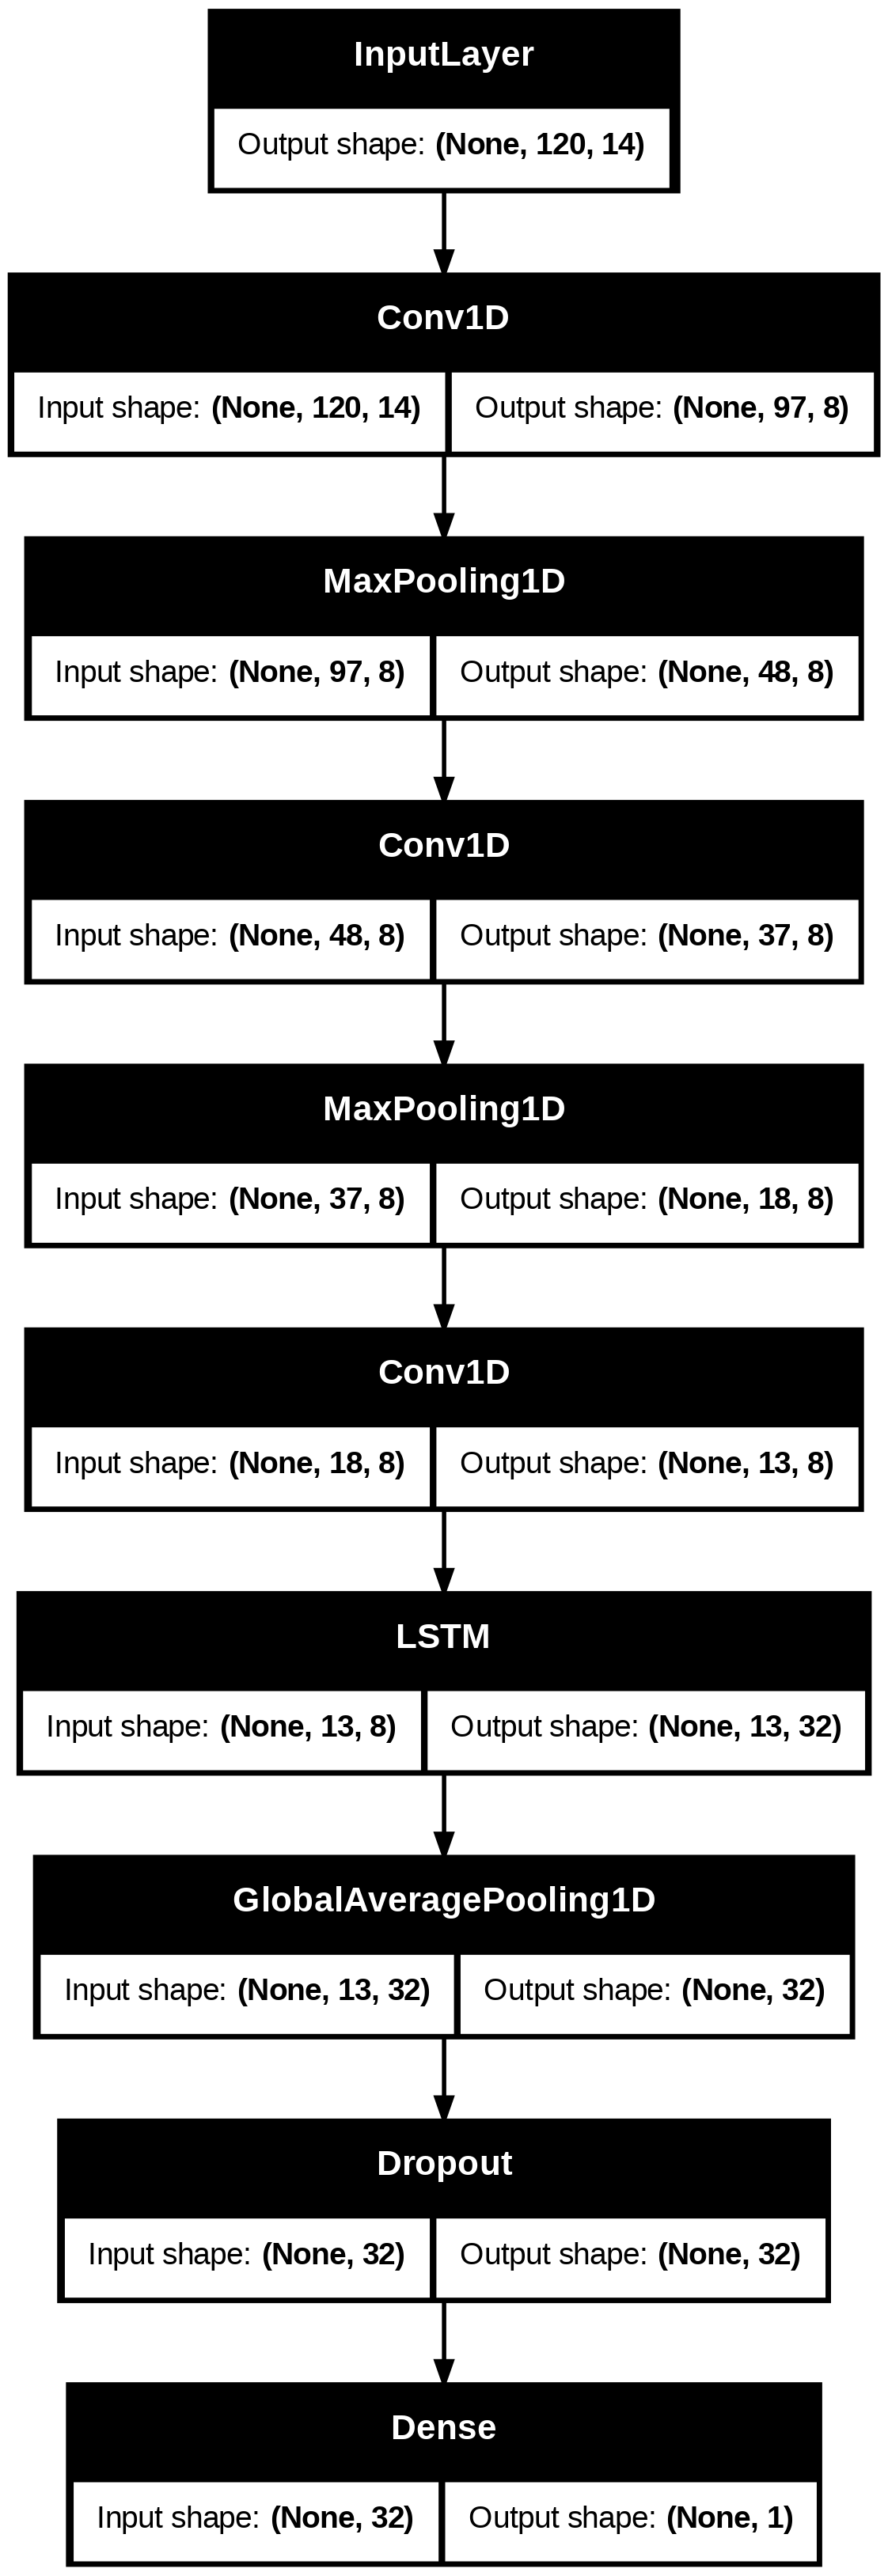

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

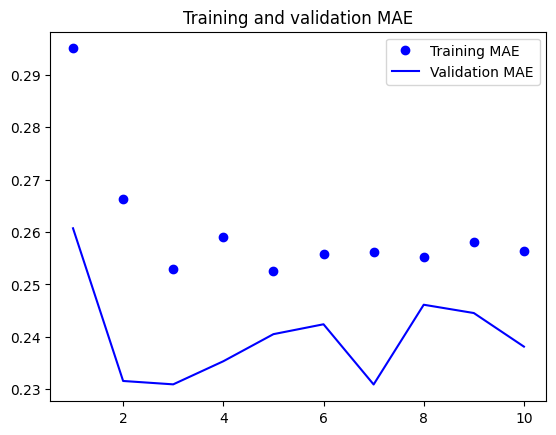

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()